In [22]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import os
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [24]:
df = pd.read_csv('../Training/X_train.csv')
y_test = pd.read_csv('../Training/y_train.csv')
test_df = pd.read_csv('../Test/X_test.csv')

df = df.merge(y_test, on='Unique_ID')

In [28]:
print(df.shape)
duplicate_rows = df.duplicated()

print('Duplicate Records : ', len(df[duplicate_rows]))

(33050, 45)
Duplicate Records :  0


### EDA

In [29]:

numerical_col = [col for col in df.columns if col.startswith('N')]
categorical_col = [col for col in df.columns if col.startswith('C')]


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33050 entries, 0 to 33049
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unique_ID           33050 non-null  object 
 1   C1                  33050 non-null  int64  
 2   C2                  33050 non-null  int64  
 3   C3                  33050 non-null  int64  
 4   C4                  33050 non-null  int64  
 5   C5                  33050 non-null  int64  
 6   C6                  33050 non-null  bool   
 7   C7                  33050 non-null  int64  
 8   C8                  33050 non-null  bool   
 9   N1                  33050 non-null  float64
 10  N2                  28438 non-null  float64
 11  N3                  32685 non-null  float64
 12  N4                  28444 non-null  float64
 13  N5                  28444 non-null  float64
 14  N6                  32685 non-null  float64
 15  N7                  32623 non-null  float64
 16  N8  

In [31]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_percentages = missing_percentage(df)
print("Percentage of missing values in each column:")
print(missing_percentages)

Percentage of missing values in each column:
                    Total    Percent
N32                 26830  81.180030
N27                 26779  81.025719
N31                 26779  81.025719
N26                 26779  81.025719
N29                 26779  81.025719
N30                 26779  81.025719
N28                 26779  81.025719
N25                 26779  81.025719
N12                  4614  13.960666
N2                   4612  13.954614
N4                   4606  13.936460
N5                   4606  13.936460
N18                  4606  13.936460
N17                  4606  13.936460
N16                  4606  13.936460
N20                  4571  13.830560
N21                  4571  13.830560
N19                  4571  13.830560
N22                  4571  13.830560
N23                  2486   7.521936
N11                   716   2.166415
N14                   608   1.839637
N10.1                 427   1.291982
N10                   427   1.291982
N15                   427   1.

Some of the Columns have More than 80% of the values as Null.
Dropping the columns with more than 80% of the values as missing.

For rest of the columns with missing values, we will fill the null values using below approach.

"Filling cat cols with mode and numerical cols with median using median."


In [ ]:
## Dropping the cols with more than 80% null values 

missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_drop = missing_percentages[missing_percentages > 80].index
columns_to_keep = list(set(df.columns) - set(columns_to_drop))
df1 = df[columns_to_keep]
df1.drop('Unique_ID', axis=1, inplace = True)


In [ ]:
columns_to_drop

Index(['N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32'], dtype='object')

In [ ]:

numerical_col = [col for col in df1.columns if col.startswith('N')]
categorical_col = [col for col in df1.columns if col.startswith('C')]


In [ ]:
## converting the boolean cols to int

boolean_cols = df1.select_dtypes(include='bool').columns
df1[boolean_cols] = df1[boolean_cols].astype(int)
df1.head()

,N33,N3,C3,C8,N11,N23,N17,C4,N10,N10.1,C7,N19,N20,N21,N34,Dependent_Variable,N16,N18,N2,N7,N6,C5,N8,N24,N22,N14,N1,C6,N4,C1,N5,N15,N9,C2,N12,N35
0,58.0,2.5,11,1,NaN,27.816,NaN,31,2.0,14.0,0,NaN,NaN,NaN,113.39,1,NaN,NaN,NaN,10.0,2.595,0,0,1750.000000,NaN,NaN,23.75,0,NaN,1,NaN,0.0,0,0,NaN,12.0
1,160.0,3.7,2,1,9.0,40.000,1944.0,66,0.0,5.0,1,25856.0,17.0,0.88,262.10,0,0.0,0.06,22.0,19.0,3.795,2,4,10833.333330,1.0,0.0,11.05,0,16.0,1,12.0,0.0,72,4,0.0,17.0
2,24.0,2.4,19,1,19.0,20.000,NaN,2,7.0,3.0,0,NaN,NaN,NaN,50.29,1,NaN,NaN,NaN,17.0,2.495,0,2,6250.000000,NaN,10.0,29.00,0,NaN,1,NaN,1.0,15,0,NaN,18.0
3,70.0,3.5,16,1,0.0,26.000,8244.0,47,0.0,0.0,4,1006.0,6.0,1.00,126.52,0,0.0,0.89,1.0,6.0,3.595,1,5,2413.666667,0.0,0.0,17.99,0,4.0,1,4.0,0.0,190,1,0.0,27.0
4,100.0,3.8,13,1,4.0,44.000,57532.0,1,0.0,1.0,6,3398.0,31.0,0.96,205.47,0,0.0,0.97,206.0,31.0,3.895,1,10,7666.666667,0.0,0.0,27.50,1,11.0,1,11.0,0.0,1504,1,0.0,21.0


#### Filling numerical cols with null values with knn imputer and cat cols with mode.

In [ ]:
df_knn_impute = df1.copy(deep=True)

knn_imputer = KNNImputer()
df_knn_impute[numerical_col] = knn_imputer.fit_transform(df_knn_impute[numerical_col])

#Impute missing values in categorical columns using mode
for col in categorical_col:
    mode_value = df_knn_impute[col].mode()[0]  # Calculate mode
    df_knn_impute[col].fillna(mode_value, inplace=True)
    
# df_knn_impute.to_csv('filled_train_df_knn_mode', index = False)

### Correlation


Correlation Heatmap for Numerical Columns:


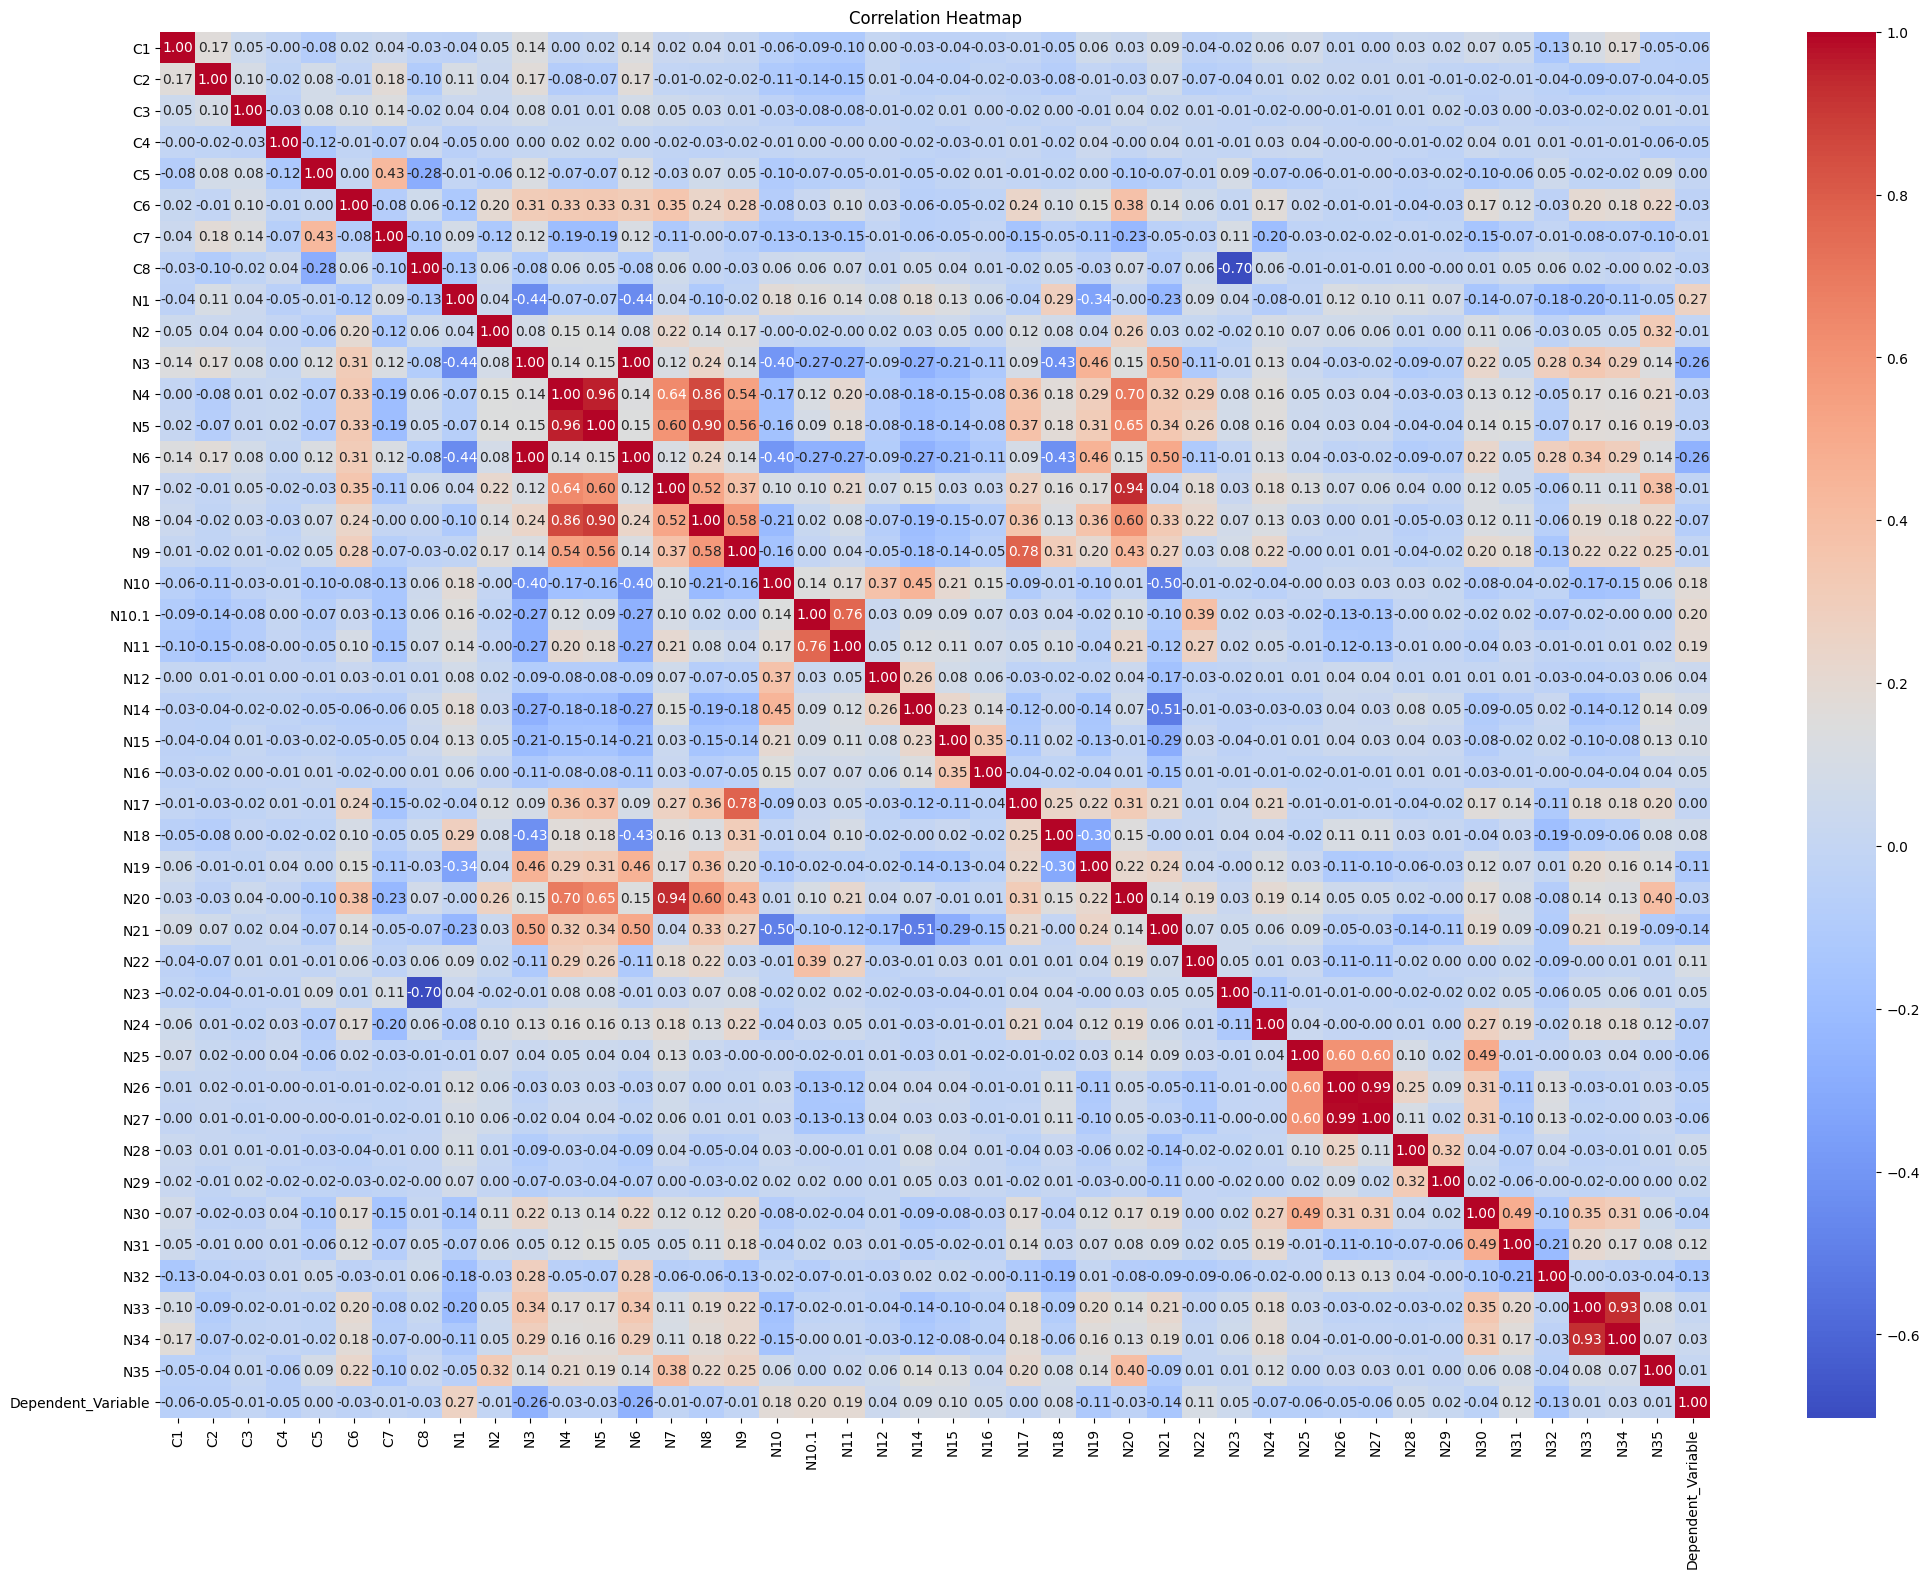

In [ ]:
# Correlation heatmap for DF columns
print("\nCorrelation Heatmap for Numerical Columns:")
plt.figure(figsize=(25,18))
sns.heatmap(df.drop('Unique_ID', axis = 1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
## Multicollinearity using VIF

def calculate_vif(df):
    features = df_knn_impute.columns
    vif_data = pd.DataFrame()
    vif_data["Features"] = features
    
    vif_data["VIF"] = [variance_inflation_factor(df_knn_impute.values, i) for i in range(df_knn_impute.shape[1])]
    return vif_data

vif_result = calculate_vif(df_knn_impute)
vif_result

,Features,VIF
0,N33,8.388076
1,N3,310056.896647
2,C3,1.055194
3,C8,1.386968
4,N11,2.513768
5,N23,1.265575
6,N17,2.796584
7,C4,1.027698
8,N10,1.703814
9,N10.1,2.497291


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def drop_high_vif_features(X, threshold=10):
    while True:
        vif_data = calculate_vif(X)
        max_vif_feature = vif_data[vif_data['VIF'] > threshold].sort_values(by='VIF', ascending=False).head(1)
        if not max_vif_feature.empty:
            feature_to_drop = max_vif_feature['Feature'].values[0]
            X = X.drop(columns=[feature_to_drop])
            print(f"Dropped feature: {feature_to_drop}")
        else:
            break
    return X

print('Runnig VIF')
df_knn_impute_no_corr = drop_high_vif_features(df_knn_impute)


Runnig VIF
Dropped feature: N6
Dropped feature: N3
Dropped feature: N5
Dropped feature: N20
Dropped feature: N21
Dropped feature: N33
Dropped feature: N4
Dropped feature: C8


### Distribution of the data

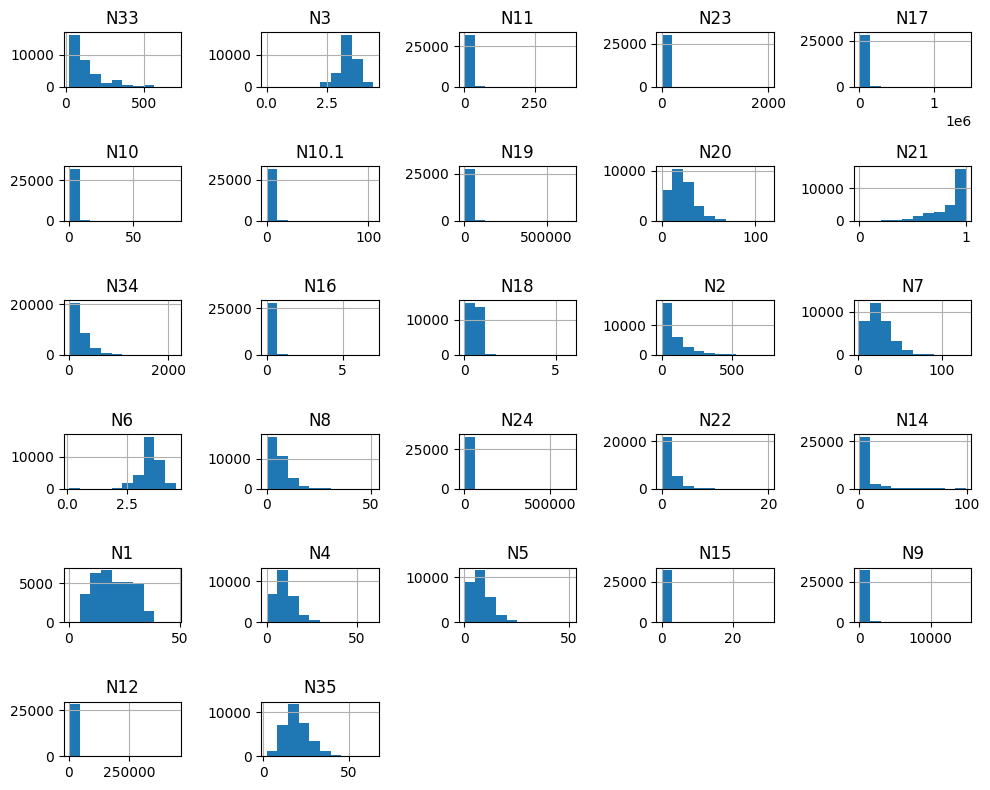

In [ ]:
df[numerical_col].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [1]:
# Pairwise scatter plots for numerical columns
# print("\nPairwise Scatter Plots for Numerical Columns:")
# sns.pairplot(df[numerical_col])
# plt.show()


### Feature Scaling


Boxplots:


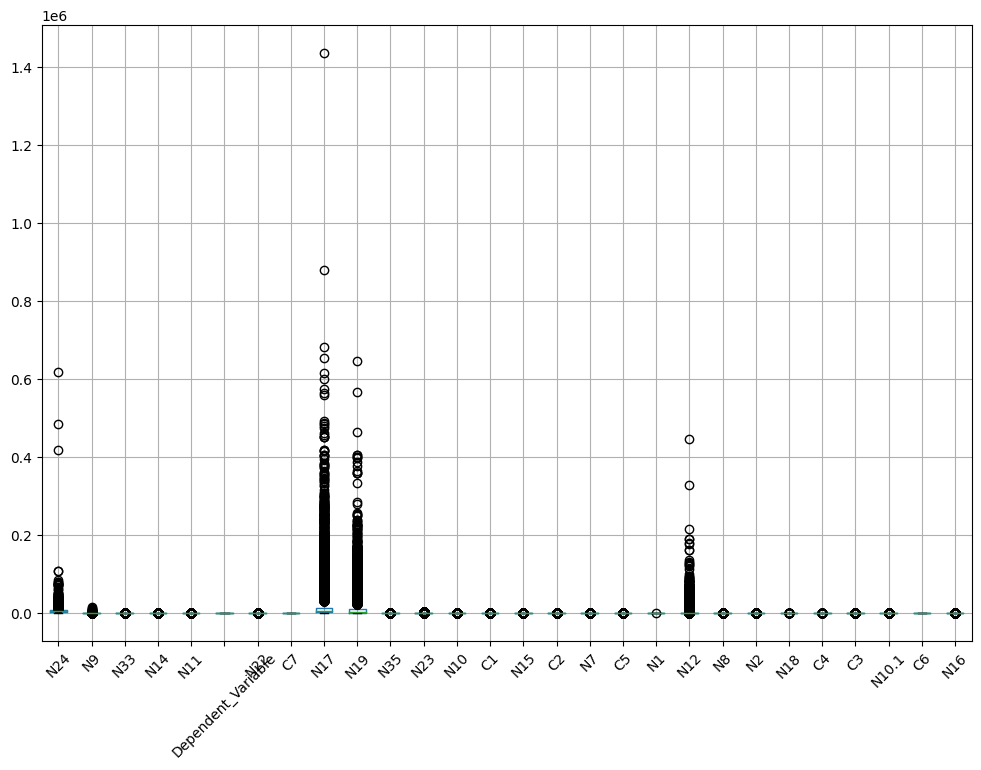

In [ ]:
# Boxplots for numerical columns
print("\nBoxplots:")
plt.figure(figsize=(12, 8))
df_fill_na_manual_no_corr.boxplot()
plt.xticks(rotation=45)
plt.show()

#### Feature scaling is required for the numerical columns, but before that, we need to get rid of outliers, else it will impact the scaling of features.

But removing outlier will significantly reduce the number of records, therefore, we are left with following methods: 
1. Cap the values above and below 3rd standard deviation.
2. Use roburst feature scaling method.

Here we should be using the roburst feature scaling methods like Standard Scaling or RoburstScaling from sklearn.

Because capping will modify the values, hence will not result in a good model.

### Data Imbalance

In [ ]:
df_knn_impute_no_corr['Dependent_Variable'].value_counts()

0    22844
1    10206
Name: Dependent_Variable, dtype: int64

In [ ]:
# Correlation with the target variable
print("\nCorrelation with the Target Variable:")
target_variable = 'Dependent_Variable'
correlation_with_target = df_knn_impute_no_corr.corr()[target_variable].sort_values(ascending=False)
correlation_with_target.reset_index()



Correlation with the Target Variable:


,index,Dependent_Variable
0,Dependent_Variable,1.000000
1,N1,0.266740
2,N10.1,0.195323
3,N11,0.189592
4,N10,0.180875
5,N15,0.098491
6,N14,0.092169
7,N22,0.090684
8,N23,0.055977
9,N16,0.052938


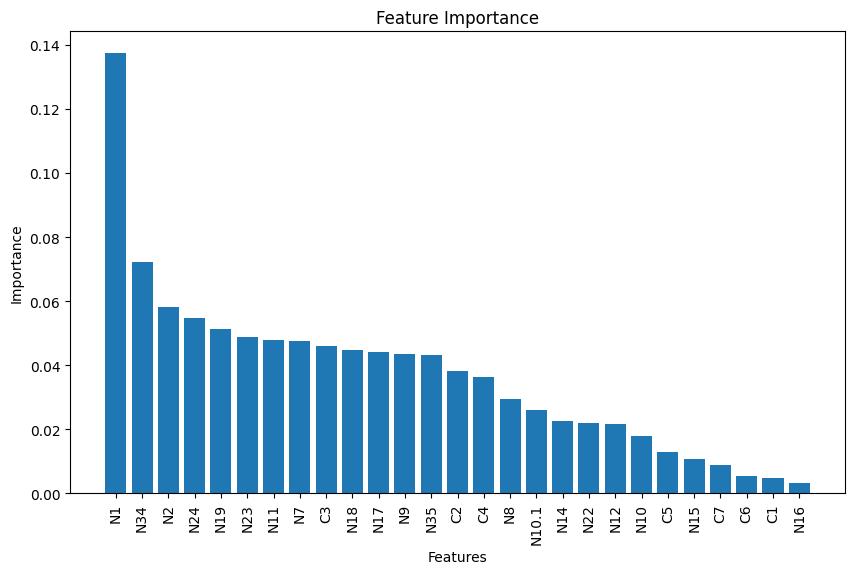

In [ ]:

X = df_knn_impute_no_corr.drop(columns=['Dependent_Variable'])
y = df_knn_impute_no_corr['Dependent_Variable']  

rf_model = RandomForestRegressor()
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()



Violin Plots for Categorical-Numerical Relationships:


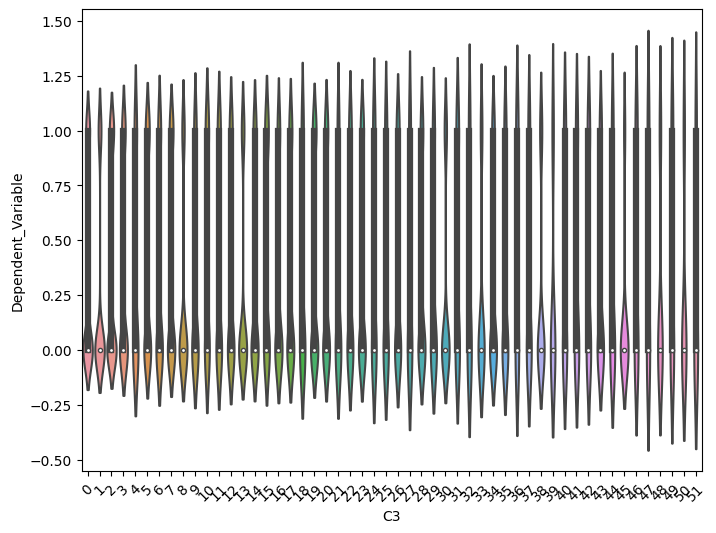

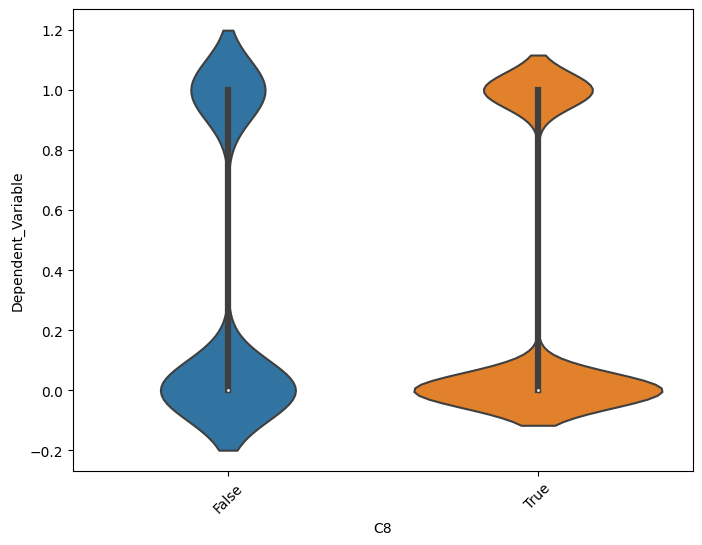

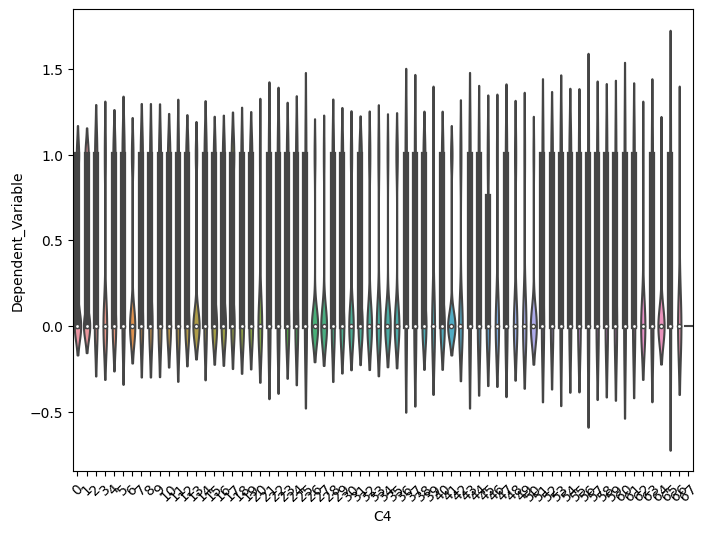

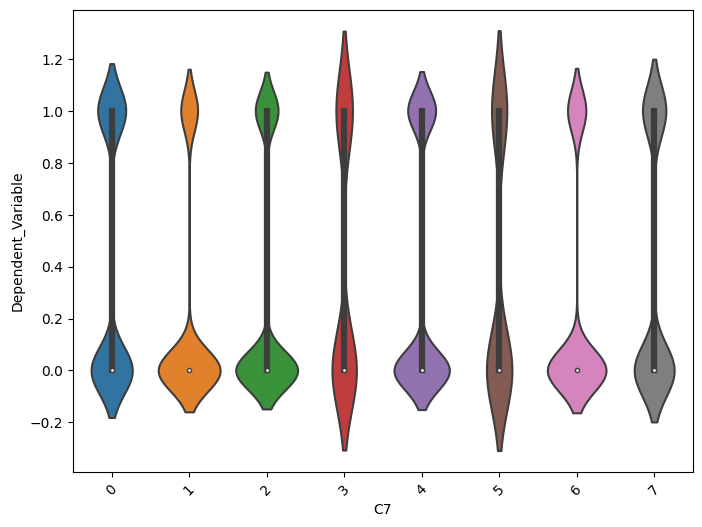

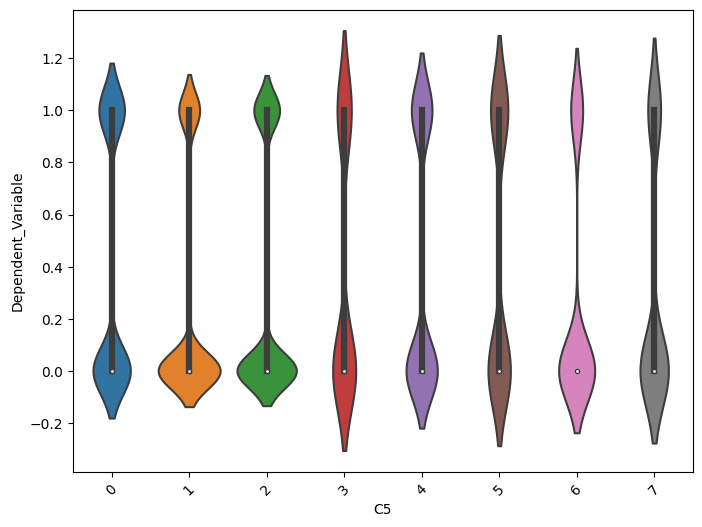

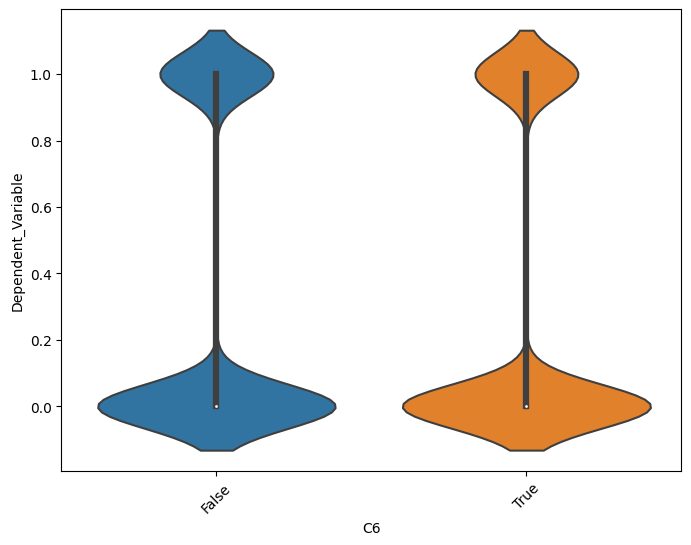

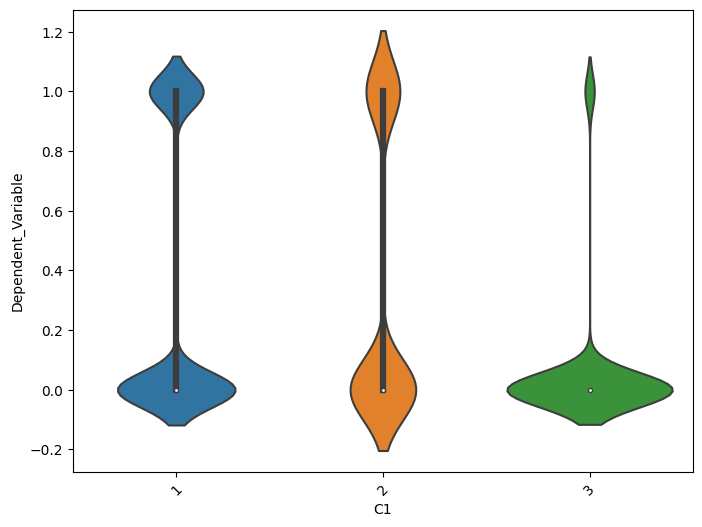

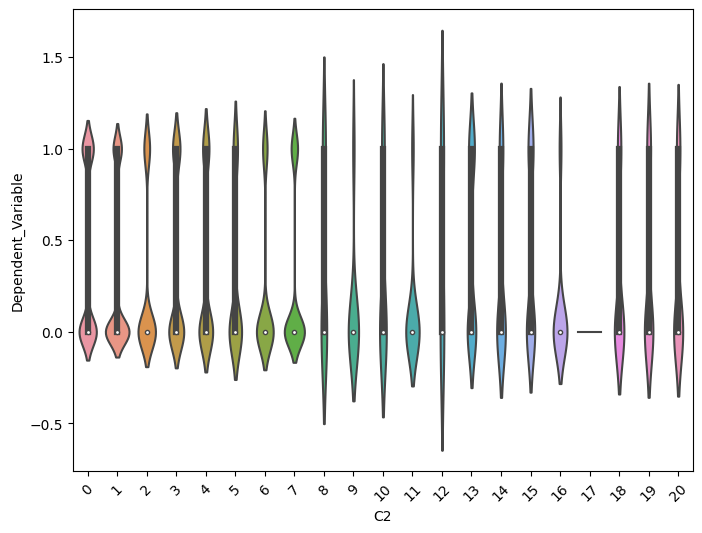

In [ ]:
# Violin plots for categorical-numerical relationships
print("\nViolin Plots for Categorical-Numerical Relationships:")
for col in df[categorical_col].columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x=col, y='Dependent_Variable')
    plt.xticks(rotation=45)
    plt.show()


## Final Data Preprocessing

In [33]:
class DataProcessor:
    def __init__(self, df):
        self.df = df

    def preprocess_data(self, oversample=True):
        print('Filling Null values')
        self.fill_null_values()
        print('Removing multicollinearity')
        self.remove_multicollinearity()
        
        # Splitting the data into train and test sets
        print('Train Test Split')
        X = self.df.drop(columns=['Dependent_Variable'])
        y = self.df['Dependent_Variable']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Selecting only columns starting with 'N' for scaling
        cols_to_scale = [col for col in X_train.columns if col.startswith('N')]
        
        # Scaling the selected columns using RobustScaler
        print('Scaling the data')
        scaler = RobustScaler()
        X_train_scaled = X_train.copy()
        X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test_scaled = X_test.copy()
        X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
        
        if oversample:
            # Oversampling using SMOTE
            print('Oversampling Data')
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
            return X_train_resampled, X_test_scaled, y_train_resampled, y_test
        else:
            return X_train_scaled, X_test_scaled, y_train, y_test

    def fill_null_values(self):
        # Dropping columns with more than 80% missing values
        missing_percentages = (self.df.isnull().sum() / len(self.df)) * 100
        columns_to_drop = missing_percentages[missing_percentages > 80].index
        self.df.drop(columns=columns_to_drop, inplace=True)
#         self.df.drop('Unique_ID', axis=1, inplace=True)

        # Separating numerical and categorical columns
        numerical_cols = [col for col in self.df.columns if col.startswith('N')]
        categorical_cols = [col for col in self.df.columns if col.startswith('C')]

        # Filling null values in numerical columns with median
        numerical_imputer = SimpleImputer(strategy='median')
        self.df[numerical_cols] = numerical_imputer.fit_transform(self.df[numerical_cols])
        
        # Filling null values in categorical columns with mode
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.df[categorical_cols] = categorical_imputer.fit_transform(self.df[categorical_cols])

    def calculate_vif(self, X):
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        return vif_data

    def remove_multicollinearity(self):
        X = self.df.drop(columns=['Dependent_Variable'])
        # Iteratively remove features with VIF > 10
        print('Dropped Cols : ')
        while True:
            vif_data = self.calculate_vif(X)
            max_vif = vif_data['VIF'].max()
            if max_vif > 10:
                max_vif_index = vif_data[vif_data['VIF'] == max_vif].index[0]
                print(X.columns[max_vif_index])
                X = X.drop(columns=[X.columns[max_vif_index]])
            else:
                break
        self.df = pd.concat([X, self.df['Dependent_Variable']], axis=1)
        

df = pd.read_csv('Training/X_train.csv')
y_train = pd.read_csv('Training/y_train.csv')
df = df.merge(y_train, on='Unique_ID')
df.drop('Unique_ID', axis = 1, inplace = True)

print('---------- Preprocessing and Oversampling Data ----------- ')
processor_oversampled = DataProcessor(df)
X_train_resampled, X_test_scaled, y_train_resampled, y_test = processor_oversampled.preprocess_data(oversample=True)

print('---------- Preprocessing without Oversampling Data ---------- ')
processor_non_oversampled = DataProcessor(df)
X_train_scaled, X_test_scaled, y_train, y_test = processor_non_oversampled.preprocess_data(oversample=False)

---------- Preprocessing and Oversampling Data ----------- 
Filling Null values
Removing multicollinearity
Dropped Cols : 
N6
N3
N5
N20
N21
N34
N4
C8
Train Test Split
Scaling the data
Oversampling Data
---------- Preprocessing without Oversampling Data ---------- 
Filling Null values
Removing multicollinearity
Dropped Cols : 
N6
N3
N5
N20
N21
N34
N4
C8
Train Test Split
Scaling the data


## Model building

## Building Logistic Regression and SVC model

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

class ClassificationModel:
    """
    This class trains and evaluates Logistic Regression, SVC, and ANN models
    for classification, using Lasso regression for feature selection,
    hyperparameter tuning via GridSearchCV, and cross-validation.

    Attributes:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.
        best_model (object): Best performing model (LogisticRegression, SVC, or MLPClassifier).
        best_params (dict): Best hyperparameters for the best model.
        best_score (float): Best cross-validation score achieved.
        selected_features (np.ndarray, optional): Feature indices representing the selected features.
        best_accuracy (float, optional): Accuracy of the best model on the test set.
        best_roc_auc (float, optional): ROC AUC score of the best model on the test set.
    """

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.best_model = None
        self.best_params = None
        self.best_score = None
        self.selected_features = None
        self.best_accuracy = None
        self.best_roc_auc = None

    def select_features_lasso(self):
        """
        Selects the most important features using Lasso regression.

        Returns:
            np.ndarray: Feature indices representing the selected features.
        """

        lasso_model = Lasso(max_iter=10000)  # Use L1 penalty for feature selection
        lasso_model.fit(self.X_train, self.y_train)
        feature_coefs = np.abs(lasso_model.coef_)
        important_feature_indices = np.where(feature_coefs > np.percentile(feature_coefs, 75))[0]  # Select top 25% features
        self.selected_features = important_feature_indices
        return important_feature_indices

    def tune_hyperparameters(self, model_type, cv=5):

        if model_type == 'logistic':
            param_grid = {
                'C': [0.01, 0.1, 1, 10]
            }
            clf = LogisticRegression(max_iter=1000)
        elif model_type == 'svc':
            param_grid = {
                'C': [0.1, 1], 
                'gamma': [0.1, 1],
                'kernel': ['linear', 'rbf']
            }
            clf = SVC(probability=True)
        elif model_type == 'ann':
            param_grid = {
                'hidden_layer_sizes': [(100,), (50, 50)], 
                'activation': ['relu'],  
                'alpha': [0.0001, 0.001], 
                'learning_rate': ['constant', 'adaptive']

            }
            clf = MLPClassifier(max_iter=1000)
        else:
            raise ValueError("Invalid model type. Choose 'logistic', 'svc', or 'ann'.")

        # Suppress ConvergenceWarning
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)

        return grid_search.best_estimator_, grid_search.best_params_


    def train_models(self):
        """
        Trains and evaluates Logistic Regression, SVC, and ANN models, performs feature selection,
        hyperparameter tuning, and selects the best model based on cross-validation score.

        Also calculates accuracy and ROC AUC score for the best model.
        """

        # Train and tune Logistic Regression
        logistic_model, logistic_params = self.tune_hyperparameters('logistic')
        logistic_model.fit(self.X_train, self.y_train)
        logistic_score = cross_val_score(logistic_model, self.X_train, self.y_train, cv=5, scoring='accuracy').mean()
        print(f"Accuracy of Logistic Regression: {logistic_score:.4f}")
        
        # Train and tune SVC
        svc_model, svc_params = self.tune_hyperparameters('svc')
        svc_model.fit(self.X_train, self.y_train)
        svc_score = cross_val_score(svc_model, self.X_train, self.y_train, cv=5, scoring='accuracy').mean()
        print(f"Accuracy of Support Vector Classifier: {svc_score:.4f}")
        # Train and tune ANN
       
        ann_model, ann_params = self.tune_hyperparameters('ann')
        ann_model.fit(self.X_train, self.y_train)
        ann_score = cross_val_score(ann_model, self.X_train, self.y_train, cv=5, scoring='accuracy').mean()
        print(f"Accuracy of Artificial Neural Network: {ann_score:.4f}")
        
        # Selects best model based on cross-validation score
        best_score = max(logistic_score, svc_score, ann_score)
        if best_score == logistic_score:
            self.best_model = logistic_model
            self.best_params = logistic_params
            self.best_score = logistic_score
        elif best_score == svc_score:
            self.best_model = svc_model
            self.best_params = svc_params
            self.best_score = svc_score
        else:
            self.best_model = ann_model
            self.best_params = ann_params
            self.best_score = ann_score

        self.best_accuracy = self.best_model.score(self.X_test, self.y_test)

        # Calculate ROC AUC score for the best model if it's not an ANN
        if type(self.best_model).__name__ != 'MLPClassifier':
            y_pred = self.best_model.predict_proba(self.X_test)[:, 1]
            self.best_roc_auc = roc_auc_score(self.y_test, y_pred)
        else:
            self.best_roc_auc = None

        print(f"Best model: {type(self.best_model).__name__}")
        print(f"Best Hyperparameters: {self.best_params}")
        print(f"Best Cross-Validation Score: {self.best_score:.4f}")
        print(f"Accuracy on Test Set: {self.best_accuracy:.4f}")
        if self.best_roc_auc is not None:
            print(f"ROC AUC Score: {self.best_roc_auc:.4f}")
        else:
            print("ROC AUC Score: N/A")
            
print("Accuracy of Logistic Regression: 0.72")            
model = ClassificationModel(X_train_resampled, X_test_scaled, y_train_resampled, y_test)
model.train_models()


##########

"""
Accuracy of Logistic Regression: 0.7215
Accuracy of Support Vector Classifier: 0.7363
"""

## Decision Tree and Ensemble model

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df

    def preprocess_data(self, oversample=False):
        print('Filling Null values')
        self.fill_null_values()
        print('Removing multicollinearity')
        self.remove_multicollinearity()
        
        # Splitting the data into train and test sets
        print('Train Test Split')
        X = self.df.drop(columns=['Dependent_Variable'])
        y = self.df['Dependent_Variable']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Selecting only columns starting with 'N' for scaling
        cols_to_scale = [col for col in X_train.columns if col.startswith('N')]
        
        # Scaling the selected columns using RobustScaler
        print('Scaling the data')
        scaler = RobustScaler()
        X_train_scaled = X_train.copy()
        X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test_scaled = X_test.copy()
        X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
        
        if oversample:
            # Oversampling using SMOTE
            print('Oversampling Data')
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
            return X_train_resampled, X_test_scaled, y_train_resampled, y_test
        else:
            return X_train_scaled, X_test_scaled, y_train, y_test

    def fill_null_values(self):
        # Dropping columns with more than 80% missing values
        missing_percentages = (self.df.isnull().sum() / len(self.df)) * 100
        columns_to_drop = missing_percentages[missing_percentages > 80].index
        self.df.drop(columns=columns_to_drop, inplace=True)
        # self.df.drop('Unique_ID', axis=1, inplace=True)

        # Separating numerical and categorical columns
        numerical_cols = [col for col in self.df.columns if col.startswith('N')]
        categorical_cols = [col for col in self.df.columns if col.startswith('C')]

        # Filled null values in numerical columns with median
        numerical_imputer = SimpleImputer(strategy='median')
        self.df[numerical_cols] = numerical_imputer.fit_transform(self.df[numerical_cols])
        
        # Filled null values in categorical columns with mode
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.df[categorical_cols] = categorical_imputer.fit_transform(self.df[categorical_cols])

    def calculate_vif(self, X):
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        return vif_data

    def remove_multicollinearity(self):
        X = self.df.drop(columns=['Dependent_Variable'])
        # Iteratively remove features with VIF > 10
        while True:
            vif_data = self.calculate_vif(X)
            max_vif = vif_data['VIF'].max()
            if max_vif > 10:
                max_vif_index = vif_data[vif_data['VIF'] == max_vif].index[0]
                print('Dropped Cols : ')
                print(X.columns[max_vif_index])
                X = X.drop(columns=[X.columns[max_vif_index]])
            else:
                break
        self.df = pd.concat([X, self.df['Dependent_Variable']], axis=1)

df = pd.read_csv('Training/X_train.csv')
y_train = pd.read_csv('Training/y_train.csv')
df = df.merge(y_train, on='Unique_ID')
df.drop('Unique_ID', axis = 1, inplace = True)

processor = DataProcessor(df)
# Preprocess data without oversampling
X_train_scaled, X_test_scaled, y_train, y_test = processor.preprocess_data(oversample=False)
# Preprocess data with oversampling
X_train_resampled, X_test_scaled, y_train_resampled, y_test = processor.preprocess_data(oversample=True)



Filling Null values
Removing multicollinearity
Dropped Cols : 
N6
Dropped Cols : 
N3
Dropped Cols : 
N5
Dropped Cols : 
N20
Dropped Cols : 
N21
Dropped Cols : 
N34
Dropped Cols : 
N4
Dropped Cols : 
C8
Train Test Split
Scaling the data
Filling Null values
Removing multicollinearity
Train Test Split
Scaling the data
Oversampling Data


### Performance of DT, RF and XGBoost without data oversampling

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd

class ModelEvaluator:
    def __init__(self, algorithm, x_train, x_test, y_train, y_test):
        self.algorithm = algorithm
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def evaluate(self):
        if self.algorithm == 'RandomForest':
            model = RandomForestClassifier()
            param_grid = {'n_estimators': [50, 100, 150],
                          'max_depth': [None, 10, 20],
                          'min_samples_split': [2, 5, 10]}
        elif self.algorithm == 'XGBoost':
            model = XGBClassifier()
            param_grid = {'n_estimators': [50, 100, 150],
                          'max_depth': [3, 5, 7],
                          'learning_rate': [0.1, 0.01, 0.001]}
        elif self.algorithm == 'DecisionTree':
            model = DecisionTreeClassifier()
            param_grid = {'max_depth': [None, 5, 10, 20],
                          'min_samples_split': [2, 5, 10]}

        # Parameter tuning using GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(self.x_train, self.y_train)

        # Best parameters and best score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Cross-validation
        cv_scores = cross_val_score(grid_search.best_estimator_, self.x_train, self.y_train, cv=5, scoring='roc_auc')

        # Final evaluation on test set
        y_pred = grid_search.predict_proba(self.x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        auc_score = auc(fpr, tpr)

        return best_params, best_score, cv_scores, auc_score


# Evaluating Decision Tree
dt_evaluator = ModelEvaluator('DecisionTree', X_train_scaled, X_test_scaled, y_train, y_test)
dt_best_params, dt_best_score, dt_cv_scores, dt_auc_score = dt_evaluator.evaluate()

print("\nDecision Tree:")
print("Best Parameters:", dt_best_params)
print("Best AUC Score:", dt_best_score)
print("Cross Validation Scores:", dt_cv_scores)
print("Test AUC Score:", dt_auc_score)


# Evaluating Random Forest
rf_evaluator = ModelEvaluator('RandomForest', X_train_scaled, X_test_scaled, y_train, y_test)
rf_best_params, rf_best_score, rf_cv_scores, rf_auc_score = rf_evaluator.evaluate()

print("Random Forest:")
print("Best Parameters:", rf_best_params)
print("Best AUC Score:", rf_best_score)
print("Cross Validation Scores:", rf_cv_scores)
print("Test AUC Score:", rf_auc_score)

# Evaluating XGBoost
xgb_evaluator = ModelEvaluator('XGBoost', X_train_scaled, X_test_scaled, y_train, y_test)
xgb_best_params, xgb_best_score, xgb_cv_scores, xgb_auc_score = xgb_evaluator.evaluate()

print("\nXGBoost:")
print("Best Parameters:", xgb_best_params)
print("Best AUC Score:", xgb_best_score)
print("Cross Validation Scores:", xgb_cv_scores)
print("Test AUC Score:", xgb_auc_score)



Decision Tree:
Best Parameters: {'max_depth': 5, 'min_samples_split': 5}
Best AUC Score: 0.7101500488340621
Cross Validation Scores: [0.70561719 0.71760491 0.69871837 0.71472962 0.71408015]
Test AUC Score: 0.7163146369583941

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}
Best AUC Score: 0.7589308352847878
Cross Validation Scores: [0.75430696 0.76106695 0.75158822 0.76202669 0.75814447]
Test AUC Score: 0.7591810604362818

XGBoost:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Best AUC Score: 0.7686356178949387
Cross Validation Scores: [0.76452465 0.77195636 0.7676714  0.77067339 0.76835229]
Test AUC Score: 0.7692130565913429


### Performance of DT, RF and XGBoost with oversampled data

In [39]:
# Evaluating Decision Tree
dt_evaluator = ModelEvaluator('DecisionTree', X_train_scaled, X_test_scaled, y_train, y_test)
dt_best_params, dt_best_score, dt_cv_scores, dt_auc_score = dt_evaluator.evaluate()

print("\nDecision Tree:")
print("Best Parameters:", dt_best_params)
print("Best AUC Score:", dt_best_score)
print("Cross Validation Scores:", dt_cv_scores)
print("Test AUC Score:", dt_auc_score)


# Evaluating Random Forest
rf_evaluator = ModelEvaluator('RandomForest', X_train_scaled, X_test_scaled, y_train, y_test)
rf_best_params, rf_best_score, rf_cv_scores, rf_auc_score = rf_evaluator.evaluate()

print("Random Forest:")
print("Best Parameters:", rf_best_params)
print("Best AUC Score:", rf_best_score)
print("Cross Validation Scores:", rf_cv_scores)
print("Test AUC Score:", rf_auc_score)

# Evaluating XGBoost
xgb_evaluator = ModelEvaluator('XGBoost', X_train_scaled, X_test_scaled, y_train, y_test)
xgb_best_params, xgb_best_score, xgb_cv_scores, xgb_auc_score = xgb_evaluator.evaluate()

print("\nXGBoost:")
print("Best Parameters:", xgb_best_params)
print("Best AUC Score:", xgb_best_score)
print("Cross Validation Scores:", xgb_cv_scores)
print("Test AUC Score:", xgb_auc_score)



Decision Tree:
Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Best AUC Score: 0.8209918691258631
Cross Validation Scores: [0.81922746 0.82795846 0.82388076 0.81660339 0.81633423]
Test AUC Score: 0.8252325952368634

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Best AUC Score: 0.8951150869173949
Cross Validation Scores: [0.89565577 0.89979126 0.89528243 0.89261101 0.88900202]
Test AUC Score: 0.8968844788966109

XGBoost:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Best AUC Score: 0.8950388910951105
Cross Validation Scores: [0.89527973 0.9017746  0.89787745 0.89054622 0.88971645]
Test AUC Score: 0.8929871254668191


### Final Model Building

In [40]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

class DataProcessor:
    def __init__(self, df):
        self.df = df

    def preprocess_data(self):
        print('Filling Null values')
        self.fill_null_values()
        print('Removing the Multicollinearity')
        self.remove_multicollinearity()

        X_train = self.df.drop(columns=['Dependent_Variable'])
        y_train = self.df['Dependent_Variable']

        cols_to_scale = [col for col in X_train.columns if col.startswith('N')]
        other_cols = [col for col in X_train.columns if col not in cols_to_scale]

        # Scaling the selected columns using RobustScaler
        print('Scaling the data')
        scaler = RobustScaler()
        X_train_scaled = X_train.copy()
        X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

        return X_train_scaled, y_train

    def fill_null_values(self):
        missing_percentages = (self.df.isnull().sum() / len(self.df)) * 100
        columns_to_drop = missing_percentages[missing_percentages > 80].index
        columns_to_keep = list(set(self.df.columns) - set(columns_to_drop))
        self.df = self.df[columns_to_keep]

        numerical_cols = [col for col in self.df.columns if col.startswith('N')]
        categorical_cols = [col for col in self.df.columns if col.startswith('C')]

        numerical_imputer = SimpleImputer(strategy='median')
        self.df[numerical_cols] = numerical_imputer.fit_transform(self.df[numerical_cols])
        
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.df[categorical_cols] = categorical_imputer.fit_transform(self.df[categorical_cols])

    def calculate_vif(self, X):
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        return vif_data

    def remove_multicollinearity(self):
        X = self.df.drop(columns=['Dependent_Variable'])
        print('Dropped Columns : ', end='')
        while True:
            vif_data = self.calculate_vif(X)
            max_vif = vif_data['VIF'].max()
            if max_vif > 10:
                max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
                print(max_vif_feature, end=', ')
                X = X.drop(columns=[max_vif_feature])
            else:
                break
        self.df = pd.concat([X, self.df['Dependent_Variable']], axis=1)
        print()


train_df = pd.read_csv('Training/X_train.csv')
y_test = pd.read_csv('/Training/y_train.csv')
df = train_df.merge(y_test, on='Unique_ID')
df.drop('Unique_ID', axis=1, inplace=True)

processor = DataProcessor(df)
X_train, y_train = processor.preprocess_data()

Filling Null values
Removing the Multicollinearity
N6
N3
N5
N20
N21
N34
N4
C8
Train Test Split
Scaling the data


In [25]:
class ModelEvaluator:
    def __init__(self, algorithm, X_train, train_cols, X_test, target):
        self.algorithm = algorithm
        self.X_train = X_train
        self.train_cols = train_cols
        self.target = target
        self.X_test = X_test
        
    def smote_oversample(self):
        smote = SMOTE(random_state=42)
        return smote.fit_resample(self.X_train[self.train_cols], self.X_train[self.target])
        

    def evaluate(self, oversample_flag=True):
        if oversample_flag:
            X_train_resampled, y_train_resampled = self.smote_oversample()
        else:
            X_train_resampled, y_train_resampled = self.X_train[self.train_cols], self.X_train[self.target]

        model = XGBClassifier(eval_metric='error')

        # Define the parameter grid
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01, 0.001],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [1, 3, 5]
        }

        # Parameter tuning using GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Best parameters and best score
        best_params = grid_search.best_params_

        # Predictions on the test data
        y_pred = grid_search.predict_proba(self.X_test[self.train_cols])[:, 1]
        self.X_test['Class_1_Probability'] = y_pred  

        return best_params, self.X_test



test_df = pd.read_csv('/kaggle/input/sample/X_test.csv')

final_train_df = pd.concat([X_train, y_train], axis=1)
train_cols = final_train_df.columns.tolist()
train_cols.remove('Dependent_Variable')

xgb_evaluator = ModelEvaluator('XGBoost', final_train_df, train_cols, test_df, 'Dependent_Variable')

xgb_best_params_no_oversample, test_predictions_no_oversample = xgb_evaluator.evaluate(oversample_flag=False)
print("\nXGBoost without oversampling:")
print("Best Parameters:", xgb_best_params_no_oversample)


XGBoost without oversampling:
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.6}


In [26]:
test_df = pd.read_csv('/kaggle/input/sample/X_test.csv')

final_train_df = pd.concat([X_train, y_train], axis=1)
train_cols = final_train_df.columns.tolist()
train_cols.remove('Dependent_Variable')

xgb_evaluator = ModelEvaluator('XGBoost', final_train_df, train_cols, test_df, 'Dependent_Variable')


xgb_best_params_oversample, test_predictions_oversample = xgb_evaluator.evaluate(oversample_flag=True)
print("\nXGBoost with oversampling:")
print("Best Parameters:", xgb_best_params_oversample)


XGBoost with oversampling:
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}


In [53]:

predictions_with_oversample = test_predictions_oversample[['Unique_ID', 'Oversample_Class_1']]
predictions_with_oversample.rename(columns = {'Class_1_Predictions' : 'no oversample'}, inplace = True)

predictions_no_oversample = test_predictions_no_oversample[['Unique_ID', 'No_oversample_Class_1']]
predictions_no_oversample.rename(columns = {'Class_1_Predictions' : 'no oversample'}, inplace = True)


Building oversampled xgb model


In [21]:
df = predictions_no_oversample.merge(predictions_with_oversample, on = 'Unique_ID')
# df.to_csv('test_data.csv', index = False)
df.head()

,Unique_ID,Oversample_Class_1,No_oversample_Class_1
0,Candidate_1602,0.784850,0.789192
1,Candidate_29650,0.695081,0.808997
2,Candidate_31061,0.599126,0.818142
3,Candidate_5768,0.750560,0.578353
4,Candidate_27059,0.731546,0.683429


In [17]:
df['Class_1_Probability'] = (df['Oversample_Class_1'] + df['No_oversample_Class_1'])/2
df = df[['Unique_ID', 'Class_1_Probability']]
df.head()

,Unique_ID,Class_1_Probability
0,Candidate_1602,0.787021
1,Candidate_29650,0.752039
2,Candidate_31061,0.708634
3,Candidate_5768,0.664457
4,Candidate_27059,0.707487


In [18]:
df.to_csv('../Test/final_predictions.csv', index = False)

In [3]:
import pandas as pd
temp = pd.read_csv('test_data.csv')
temp.head()

,Unique_ID,Oversample_Class_1,No_oversample_Class_1
0,Candidate_1602,0.784850,0.789192
1,Candidate_29650,0.695081,0.808997
2,Candidate_31061,0.599126,0.818142
3,Candidate_5768,0.750560,0.578353
4,Candidate_27059,0.731546,0.683429


In [5]:
sample_df = pd.read_csv('../sample_submission_file.csv')
sample_df.shape

(11017, 2)

In [8]:
print(len(set(sample_df['Unique_ID']) - set(temp['Unique_ID'])))
print(len(set(temp['Unique_ID']) - set(sample_df['Unique_ID'])))

11017
11017
